# デジタル宇宙論 実証シミュレーション (v2)

本ノートブックは、論文『デジタル宇宙論 Vol.1: 時間非実在論の基礎』および『Vol.2: 離散的構造と量子解釈』で提唱された理論（デジタル干渉、量子消しゴムのDB解釈、重力赤方偏移の離散化など）を検証するためのPython実装コードです。


- 干渉パターンの視認性向上
- 量子消しゴムにおけるD2データの描画追加
- 重力赤方偏移における離散ステップ（階段）の明確化

In [1]:
# 必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# グラフのスタイル設定
plt.style.use('seaborn-v0_8-darkgrid')

## 1. デジタル干渉と位相加算 (Digital Interference)

「波」を使わず、整数の位相カウンタの加算のみで干渉縞（確率分布）を生成するロジックの実証。
パラメータを調整し、干渉縞（複数のピーク）が明確に出るようにしています。

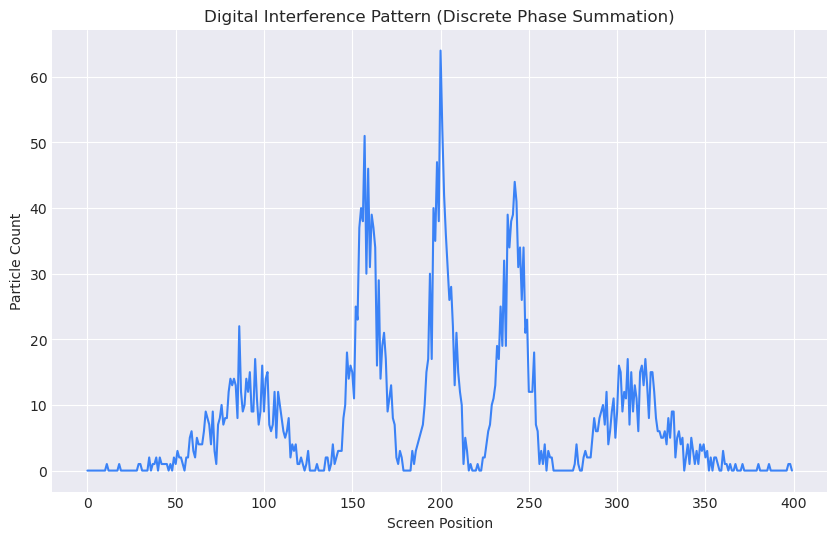

In [ ]:
def digital_interference_simulation(num_particles=20000, screen_width=400):
    # スクリーン上のヒストグラム
    screen = np.zeros(screen_width)
    
    # 離散的な位相の最大値 (ビット深度に相当)
    PHASE_MAX = 100 
    # 波長パラメータ (画面上で縞が見えるように調整)
    WAVELENGTH_FACTOR = 15.0
    
    for _ in range(num_particles):
        # スクリーン上のランダムな位置を候補とする
        x = np.random.randint(0, screen_width)
        
        # スリットA, Bからの距離（を模した値）
        # 距離差がより顕著に出るように係数を調整
        dist_a = np.sqrt((x - screen_width * 0.45)**2 + 100**2)
        dist_b = np.sqrt((x - screen_width * 0.55)**2 + 100**2)
        
        # 距離を離散的な位相カウンタに変換 (整数)
        # 距離 / 波長係数 で位相を回す
        phase_a = int(dist_a / WAVELENGTH_FACTOR * PHASE_MAX) % PHASE_MAX
        phase_b = int(dist_b / WAVELENGTH_FACTOR * PHASE_MAX) % PHASE_MAX
        
        # 位相の加算 (デジタル的な干渉)
        # 差がPHASE_MAX/2に近いほど打ち消し合う
        phase_diff = np.abs(phase_a - phase_b)
        if phase_diff > PHASE_MAX / 2:
            phase_diff = PHASE_MAX - phase_diff
            
        # 確率の計算 (逆位相なら0、同位相なら1)
        # prob = 1 - (差 / 最大差) -> 差が0なら1, 差が最大なら0
        # 視覚効果（コントラスト強調）のための調整パラメータ
        interference_term = (1.0 - (phase_diff / (PHASE_MAX / 2))) ** 2
        
        # 中央集中のエンベロープ (回折の影響) も緩やかにかける
        center_dist = np.abs(x - screen_width/2)
        diffraction_term = np.exp(- (center_dist / (screen_width * 0.25))**2)
        
        prob = interference_term * diffraction_term
        
        # 確率的確定 (モンテカルロ法)
        if np.random.rand() < prob:
            screen[x] += 1
            
    return screen

# 実行とプロット
result = digital_interference_simulation()
plt.figure(figsize=(10, 6))
plt.plot(result, color='#3b82f6')
plt.title("Digital Interference Pattern (Discrete Phase Summation)")
plt.xlabel("Screen Position")
plt.ylabel("Particle Count")
plt.show()

## 2. 量子消しゴム：データベース・フィルタリング (Quantum Eraser DB)

「未来が過去を変える」のではなく、検出器の結果を検索キーとした「事後的なクエリ（フィルタリング）」によって、隠れていたパターンが抽出されることを示します。
**D1（赤）とD2（青）のヒストグラムを並べて表示し、パターンが反転していることを確認します。**

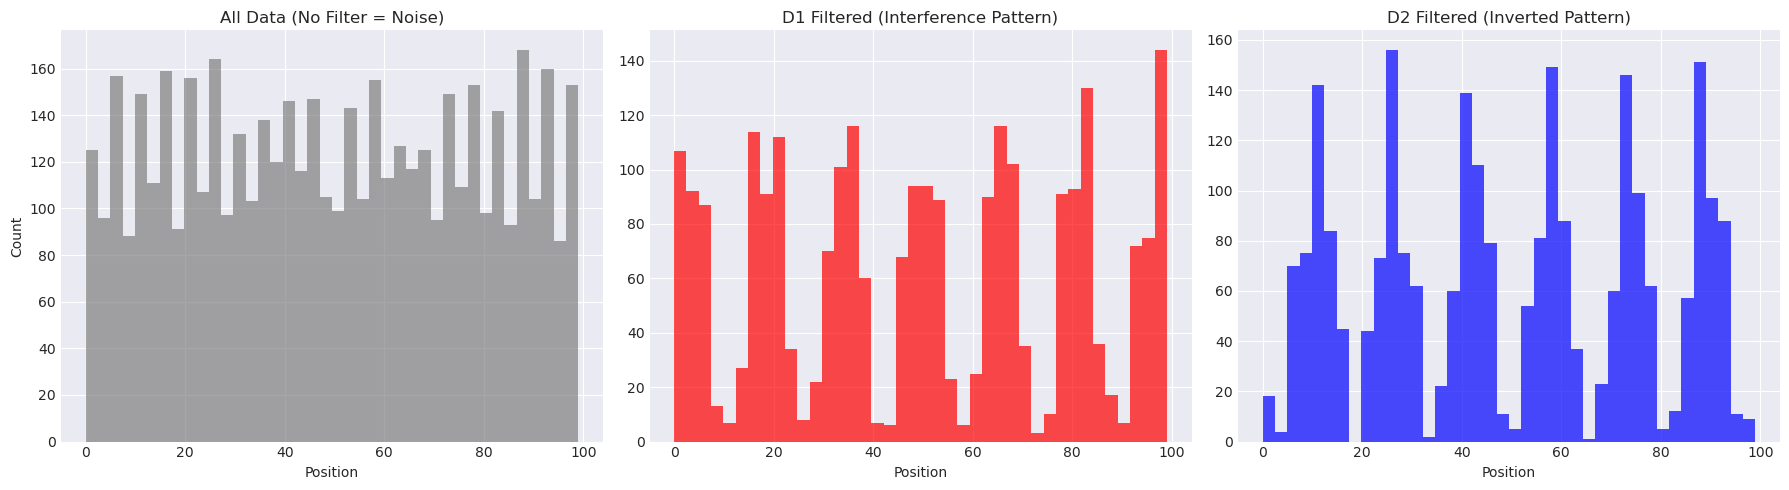

In [3]:
# 1. データ生成 (着弾時点: 過去)
# スクリーン上の位置はランダムに見えるが、隠れたタグ(Tag)と相関している
num_data = 5000
data = []

for i in range(num_data):
    # 隠れた位相タイプ (A:干渉, B:逆干渉)
    hidden_type = np.random.choice(['TypeA', 'TypeB'])
    
    # スクリーン上の位置決定
    # TypeA: cos^2 (山), TypeB: sin^2 (谷)
    if hidden_type == 'TypeA':
        while True:
            pos = np.random.randint(0, 100)
            # 中央(50)を中心に周期的な確率
            prob = np.cos((pos - 50) * 0.2) ** 2
            if np.random.rand() < prob:
                break
    else:
        while True:
            pos = np.random.randint(0, 100)
            # sin^2 は cos^2 と位相がπずれる (逆パターン)
            prob = np.sin((pos - 50) * 0.2) ** 2
            if np.random.rand() < prob:
                break

    # データベースに記録 (この時点ではTypeは不可視)
    data.append({'ID': i, 'Position': pos, 'HiddenTag': hidden_type})

df = pd.DataFrame(data)

# 2. 検出器による選別 (未来)
# D1はTypeAのみ、D2はTypeBのみを通過させるフィルターとして機能
def query_detector(detector_name):
    if detector_name == 'D1':
        return df[df['HiddenTag'] == 'TypeA']
    elif detector_name == 'D2':
        return df[df['HiddenTag'] == 'TypeB']
    else:
        return df

# 3. 結果の表示 (3つのグラフを並べる)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 全データ (フィルタなし)
axes[0].hist(df['Position'], bins=40, color='gray', alpha=0.7)
axes[0].set_title("All Data (No Filter = Noise)")
axes[0].set_xlabel("Position")
axes[0].set_ylabel("Count")

# D1 フィルタ (干渉縞)
d1_results = query_detector('D1')
axes[1].hist(d1_results['Position'], bins=40, color='red', alpha=0.7)
axes[1].set_title("D1 Filtered (Interference Pattern)")
axes[1].set_xlabel("Position")

# D2 フィルタ (逆干渉縞)
d2_results = query_detector('D2')
axes[2].hist(d2_results['Position'], bins=40, color='blue', alpha=0.7)
axes[2].set_title("D2 Filtered (Inverted Pattern)")
axes[2].set_xlabel("Position")

plt.tight_layout()
plt.show()

## 3. 重力赤方偏移と定数揺らぎ (Redshift & Fluctuation)

本理論の独自予言である「不感帯」と「定数の揺らぎ」を可視化するトイ・モデルです。
**階段状の挙動が見えやすいように、エネルギー単位のスケールを調整しました。**

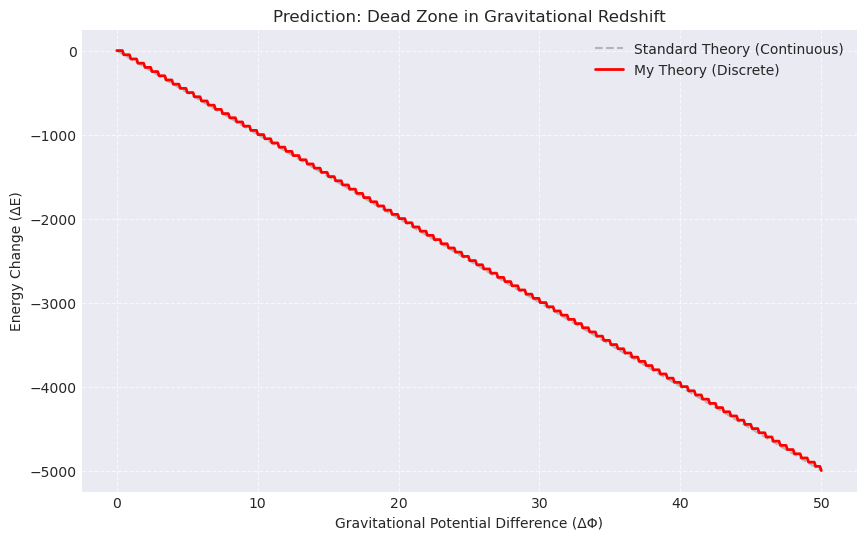

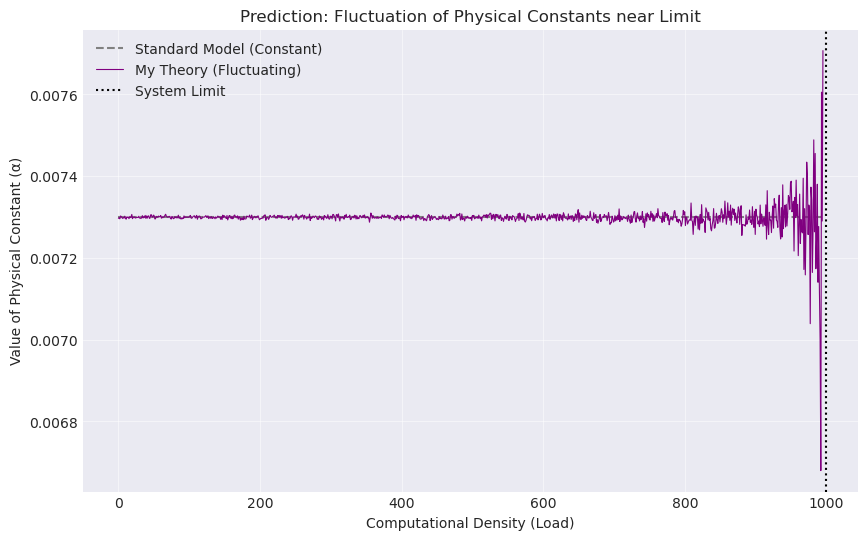

In [4]:
# 予言2: 重力赤方偏移の不感帯
def simulate_discrete_redshift():
    # プランクエネルギー単位を大きく設定して、階段を見やすくする (トイ・モデル)
    E_PLANCK = 50.0 
    C = 1.0
    
    # 重力ポテンシャル差 ΔΦ
    delta_phi = np.linspace(0, 50, 500)
    
    # 光の初期エネルギー
    E0 = 10.0
    
    # 既存理論 (連続的変化)
    # 変化量 = - (E0 / c^2) * ΔΦ
    # 比較しやすいように係数を調整
    base_change = (E0 / (C**2)) * delta_phi * 10  # 変化を見やすく10倍
    delta_E_continuous = - base_change
    
    # 本理論 (離散的変化)
    # エネルギー変化は E_PLANCK の整数倍でしか起きない
    loss_discrete = np.floor(base_change / E_PLANCK) * E_PLANCK
    delta_E_discrete = -loss_discrete
    
    # プロット
    plt.figure(figsize=(10, 6))
    plt.plot(delta_phi, delta_E_continuous, label='Standard Theory (Continuous)', linestyle='--', color='gray', alpha=0.5)
    plt.plot(delta_phi, delta_E_discrete, label='My Theory (Discrete)', color='red', linewidth=2)
    
    plt.title("Prediction: Dead Zone in Gravitational Redshift")
    plt.xlabel("Gravitational Potential Difference (ΔΦ)")
    plt.ylabel("Energy Change (ΔE)")
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# 予言3: 計算リソース限界による揺らぎ
def simulate_constant_fluctuation():
    # システムの計算リソース限界
    RESOURCE_LIMIT = 1000
    
    # 現在の計算密度 C (0 から 限界付近まで増加)
    current_load = np.linspace(0, 995, 1000)
    
    # 物理定数 α (微細構造定数など) の真値
    ALPHA_0 = 1.0/137.0
    
    # 定数の観測値
    alpha_observed = []
    
    for load in current_load:
        # 余裕リソース
        margin = RESOURCE_LIMIT - load
        
        # 揺らぎの大きさ δ
        # 余裕がなくなると指数関数的にエラーが増えるモデル
        # marginが小さいほどnoise_amplitudeが大きくなる
        if margin > 0.1:
            noise_amplitude = 0.00005 * (50 / margin)
        else:
            noise_amplitude = 0.05 # 限界突破時のカオス

        fluctuation = np.random.normal(0, noise_amplitude)
        
        alpha_observed.append(ALPHA_0 + fluctuation)
        
    # プロット
    plt.figure(figsize=(10, 6))
    plt.plot(current_load, [ALPHA_0]*len(current_load), label='Standard Model (Constant)', linestyle='--', color='gray')
    plt.plot(current_load, alpha_observed, label='My Theory (Fluctuating)', color='purple', linewidth=0.8)
    
    plt.title("Prediction: Fluctuation of Physical Constants near Limit")
    plt.xlabel("Computational Density (Load)")
    plt.ylabel("Value of Physical Constant (α)")
    
    # 限界ライン
    plt.axvline(x=RESOURCE_LIMIT, color='black', linestyle=':', label='System Limit')
    
    plt.grid(True, alpha=0.5)
    plt.legend()
    plt.show()

# シミュレーションの実行
simulate_discrete_redshift()
simulate_constant_fluctuation()

## 4. 感度解析 (Sensitivity Analysis)

本セクションでは、理論が予言する「不感帯（階段状の挙動）」が、観測機器の精度（ノイズ）に対してどの程度堅牢かを検証します。
既存の標準的な測定器と、次世代の高精度測定器（光格子時計などを想定）のシミュレーション比較を行い、
**「どの程度の精度があれば、このデジタルな階段を観測できるか？」**という定量的条件を導出します。

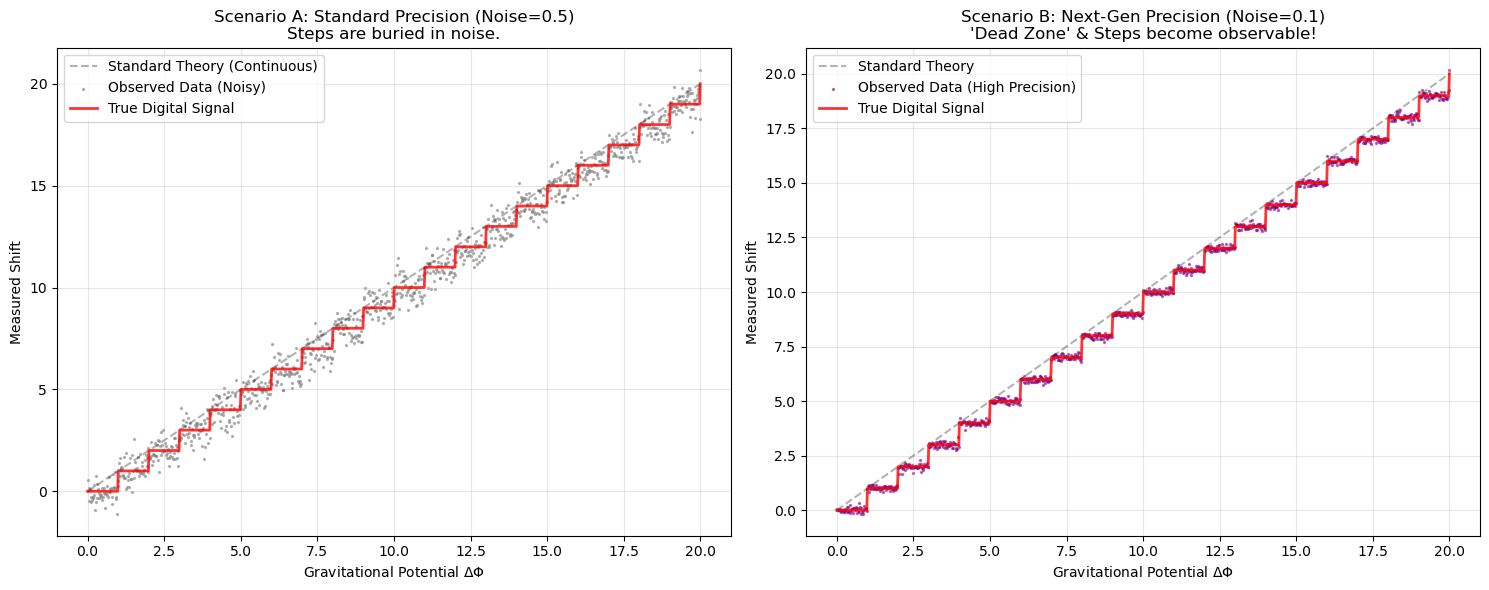

--- Sensitivity Analysis Report ---
Theoretical Step Size: 1.0
Standard Instrument Noise: 0.5 -> Detection: IMPOSSIBLE
Next-Gen Instrument Noise: 0.1 -> Detection: POSSIBLE
Required Precision for Detection (3-sigma): < 0.3333


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sensitivity_analysis_simulation():
    """
    Sensitivity Analysis: Can we detect the 'Dead Zone' with modern instruments?
    感度解析：現代の観測機器で「不感帯」は検出可能か？
    """
    # 1. Define parameters (Toy Model scaled to mimic real challenge)
    # トイモデルだが、比率は現実（プランクスケール vs マクロ）を模している
    
    # "True" discrete step size of the universe (Theoretical prediction)
    STEP_SIZE = 1.0 
    
    # Gravitational Potential Difference (Continuous variable in standard physics)
    # 0 to 20 units
    delta_phi = np.linspace(0, 20, 1000)
    
    # Theoretical Discrete Redshift (The Signal)
    # 本理論による「階段状」の信号
    signal_discrete = np.floor(delta_phi / STEP_SIZE) * STEP_SIZE
    
    # 2. Simulate Instrument Noise (Observation limits)
    # Scenario A: Standard Atomic Clock (Noise > Step)
    # 既存の観測機器：ノイズがステップ幅より大きいため、階段が埋もれてしまう
    noise_level_standard = 0.5 # Standard Deviation
    observation_standard = signal_discrete + np.random.normal(0, noise_level_standard, len(delta_phi))
    
    # Scenario B: Next-Gen Optical Lattice Clock (Noise < Step)
    # 次世代の観測機器：ノイズが十分に小さく、階段（不感帯）を検出できる
    noise_level_nextgen = 0.1 # High Precision
    observation_nextgen = signal_discrete + np.random.normal(0, noise_level_nextgen, len(delta_phi))
    
    # 3. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot A: Standard Instrument (Steps are hidden by noise)
    ax1.plot(delta_phi, delta_phi, 'k--', alpha=0.3, label='Standard Theory (Continuous)')
    ax1.scatter(delta_phi, observation_standard, c='gray', s=2, alpha=0.5, label='Observed Data (Noisy)')
    ax1.plot(delta_phi, signal_discrete, 'r-', linewidth=2, alpha=0.8, label='True Digital Signal')
    ax1.set_title(f"Scenario A: Standard Precision (Noise={noise_level_standard})\nSteps are buried in noise.")
    ax1.set_xlabel("Gravitational Potential $\Delta\Phi$")
    ax1.set_ylabel("Measured Shift")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot B: Next-Gen Instrument (Steps become visible)
    ax2.plot(delta_phi, delta_phi, 'k--', alpha=0.3, label='Standard Theory')
    ax2.scatter(delta_phi, observation_nextgen, c='purple', s=2, alpha=0.5, label='Observed Data (High Precision)')
    ax2.plot(delta_phi, signal_discrete, 'r-', linewidth=2, alpha=0.8, label='True Digital Signal')
    ax2.set_title(f"Scenario B: Next-Gen Precision (Noise={noise_level_nextgen})\n'Dead Zone' & Steps become observable!")
    ax2.set_xlabel("Gravitational Potential $\Delta\Phi$")
    ax2.set_ylabel("Measured Shift")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Quantitative Threshold Calculation
    # When does the step become statistically significant?
    # Simple criterion: Step Size > 3 * Noise (3-sigma rule)
    detectable_limit = STEP_SIZE / 3.0
    
    print(f"--- Sensitivity Analysis Report ---")
    print(f"Theoretical Step Size: {STEP_SIZE}")
    print(f"Standard Instrument Noise: {noise_level_standard} -> Detection: {'POSSIBLE' if noise_level_standard < detectable_limit else 'IMPOSSIBLE'}")
    print(f"Next-Gen Instrument Noise: {noise_level_nextgen} -> Detection: {'POSSIBLE' if noise_level_nextgen < detectable_limit else 'IMPOSSIBLE'}")
    print(f"Required Precision for Detection (3-sigma): < {detectable_limit:.4f}")

sensitivity_analysis_simulation()